# Deep Learning
## Practice Projects
# P5: Decor Colorization. Part 1

## Step 0. Style and Libraries
Let's choose a style of the Jupyter notebook and import the software libraries. The command hide_code will hide the code cells.

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: aliceblue;} 
a {color: #4876ff; font-family: 'Roboto';} 
h1 {color: #348ABD; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Roboto'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #348ABD; font-family: 'Orbitron';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #4876ff;}      
div.output_stderr pre {background-color: aliceblue;}  
div.output_stderr {background-color: slategrey;}                        
</style>
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    };
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: #348ABD; background: aliceblue; opacity: 0.8;" \ 
type="submit" value="Click to display or hide code cells">
</form>                  

In [2]:
hide_code = ''
import numpy as np 
import pandas as pd
import tensorflow as tf

from IPython.core.magic import (register_line_magic, register_cell_magic)
from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from keras.utils import to_categorical
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint, TensorBoard 
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img

from keras import backend
from keras import losses
from keras.engine.topology import Layer
from keras.optimizers import Adam, Nadam
from keras.engine import InputLayer
from keras.models import Sequential, load_model, Model

from keras.layers import Input, BatchNormalization, Flatten, Dropout
from keras.layers import Dense, LSTM, Activation, LeakyReLU
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import UpSampling2D, Conv2DTranspose
from keras.layers.core import RepeatVector, Permute
from keras.layers import Reshape, concatenate, merge

# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage import color, measure
from skimage.transform import resize as skimage_resize
from skimage.io import imsave

Using TensorFlow backend.


In [3]:
hide_code
from keras import __version__
print('keras version:', __version__)
print('tensorflow version:', tf.__version__)

keras version: 2.1.3
tensorflow version: 1.0.0


In [4]:
hide_code
# Plot the neural network fitting history
def history_plot(fit_history):
    plt.figure(figsize=(18, 12))
    
    plt.subplot(211)
    plt.plot(fit_history.history['loss'], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_loss'], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title('Loss Function');  
    
    plt.subplot(212)
    plt.plot(fit_history.history['acc'], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_acc'], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")    
    plt.legend()
    plt.title('Accuracy');

## Step 1. Load and Explore the Data
For this project, I have created the dataset of color images (150x150x3) with traditional patterns. Run the following cells to download the data.

In [5]:
hide_code
# Function for processing an image
def image_to_tensor(img_path, folder_path):
    img = keras_image.load_img(folder_path + img_path, target_size=(150, 150))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)
# Function for creating the data tensor
def data_to_tensor(img_paths, folder_path):
    list_of_tensors = [image_to_tensor(img_path, folder_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)
ImageFile.LOAD_TRUNCATED_IMAGES = True 

In [6]:
hide_code
# Load the dataset 
data = pd.read_csv("decor.txt")
files = data['file']

countries = data['country_label'].as_matrix()
decors = data['decor_label'].as_matrix()
types = data['type_label'].as_matrix()

images = data_to_tensor(files, "data/");

100%|██████████| 485/485 [00:14<00:00, 12.52it/s]


In [7]:
hide_code
# Print the shape 
print ('Image shape:', images.shape)
print ('Country shape:', countries.shape)
print ('Decor shape:', decors.shape)
print ('Type shape:', types.shape)

Image shape: (485, 150, 150, 3)
Country shape: (485,)
Decor shape: (485,)
Type shape: (485,)


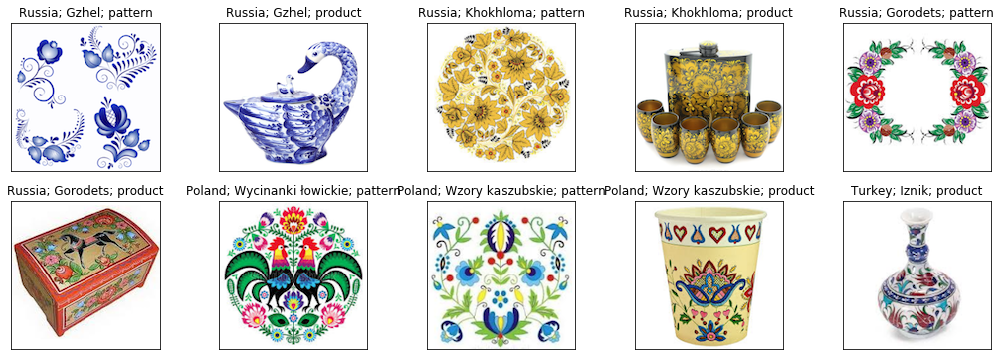

In [8]:
hide_code
# Read from files and display images using OpenCV
def display_images(img_path, ax):
    img = cv2.imread("data/" + img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(18, 6))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[], 
                         title=data['country'][i*48]+'; '+data['decor'][i*48]+'; '+data['type'][i*48])
    display_images(files[i*48], ax)

## Step 2. Save and Load the Data
The data tensors can be saved in the appropriate format of files .h5.

In [10]:
hide_code
# Create the tensor file
with h5py.File('DecorColorImages.h5', 'w') as f:
    f.create_dataset('images', data = images)
    f.create_dataset('countries', data = countries)
    f.create_dataset('decors', data = decors)
    f.create_dataset('types', data = types)
    f.close()

In [11]:
hide_code
# Read the h5 file
f = h5py.File('DecorColorImages.h5', 'r')

# List all groups
keys = list(f.keys())
keys

['countries', 'decors', 'images', 'types']

In [12]:
hide_code
# Create tensors and targets
countries = np.array(f[keys[0]])
decors = np.array(f[keys[1]])
images = np.array(f[keys[2]])
types = np.array(f[keys[3]])

print ('Image shape:', images.shape)
print ('Country shape:', countries.shape)
print ('Decor shape:', decors.shape)
print ('Type shape:', types.shape)

Image shape: (485, 150, 150, 3)
Country shape: (485,)
Decor shape: (485,)
Type shape: (485,)


In [13]:
hide_code
# Create a csv file
images_csv = images.reshape(485,150*150*3)
np.savetxt("decor_images.csv", images_csv, fmt='%i', delimiter=",")

In [14]:
hide_code
# Read the pandas dataframe from csv
data_images = pd.read_csv("decor_images.csv", header=None)
data_images.iloc[:10,:10]

,0,1,2,3,4,5,6,7,8,9
0,253,253,255,253,253,255,253,253,255,253
1,255,255,255,255,255,255,255,255,255,255
2,255,255,255,255,255,255,255,255,255,255
3,255,255,255,255,255,255,255,255,255,255
4,255,255,255,255,255,255,255,255,255,255
5,254,254,255,255,255,255,255,255,255,255
6,255,255,255,255,255,255,255,255,255,255
7,255,255,255,255,255,255,255,255,255,255
8,255,255,255,255,255,255,255,255,255,255
9,255,255,255,255,255,255,255,255,255,255


In [15]:
hide_code
# Read image tensors from the dataframe
images = data_images.as_matrix()
images = images.reshape(-1,150,150,3)

## Step 3. Implement Preprocess Functions

In [9]:
hide_code
# Normalize the tensors
images = images.astype('float32')/255

Country:  1 - Russia
Decor:  2 - Khokhloma
Type:  1 - pattern


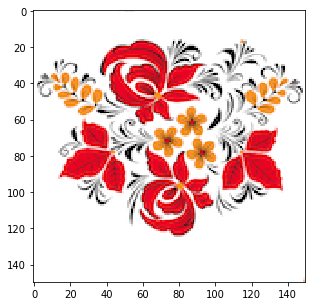

In [10]:
hide_code
# Read and display a tensor using Matplotlib
pattern_number = 106
print('Country: ', countries[pattern_number], '-', data['country'][pattern_number])
print('Decor: ', decors[pattern_number], '-', data['decor'][pattern_number])
print('Type: ', types[pattern_number], '-', data['type'][pattern_number])
plt.figure(figsize=(5,5))
plt.imshow(images[pattern_number]);

In [11]:
hide_code
# Grayscaled tensors
gray_images = np.dot(images[...,:3], [0.299, 0.587, 0.114])
print ("Shape of grayscaled images:", gray_images.shape)

Shape of grayscaled images: (485, 150, 150)


Country:  1 - Russia
Decor:  2 - Khokhloma
Type:  1 - pattern


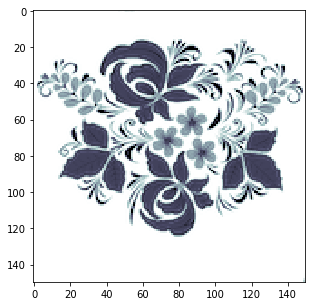

In [12]:
hide_code
# Read and display a grayscaled tensor using Matplotlib
print('Country: ', countries[pattern_number], '-', data['country'][pattern_number])
print('Decor: ', decors[pattern_number], '-', data['decor'][pattern_number])
print('Type: ', types[pattern_number], '-', data['type'][pattern_number])
plt.figure(figsize=(5,5))
plt.imshow(gray_images[pattern_number], cmap=cm.bone);

In [13]:
hide_code
# Vectorize an image example / Just for fun
@register_line_magic
def vector(number):
    example = images[int(number)]
    gray_example = color.colorconv.rgb2grey(example)
    contours = measure.find_contours(gray_example, 0.85)
    plt.figure(figsize=(8,8))
    plt.gca().invert_yaxis()
    for n, contour in enumerate(contours):
        plt.plot(contour[:, 1], contour[:, 0], lw=1)

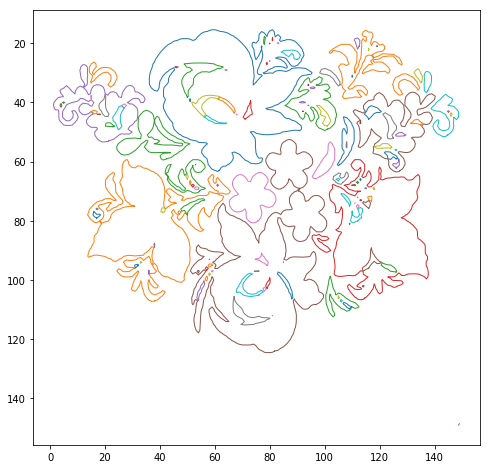

In [14]:
hide_code
# Display a vector image using the magic command
%vector 106

In [15]:
hide_code
# Print the target unique values
print('Countries: ', set(countries))
print('Decors: ', set(decors))
print('Types: ', set(types))

Countries:  {1, 2, 3, 4}
Decors:  {1, 2, 3, 4, 5, 6, 7}
Types:  {1, 2}


In [16]:
# One-hot encode the targets, started from the zero label
cat_countries = to_categorical(np.array(countries-1), 4)
cat_decors = to_categorical(np.array(decors-1), 7)
cat_types = to_categorical(np.array(types-1), 2)
cat_countries.shape, cat_decors.shape, cat_types.shape

((485, 4), (485, 7), (485, 2))

In [17]:
# Create multi-label targets
targets = np.concatenate((cat_countries, cat_decors), axis=1)
targets = np.concatenate((targets, cat_types), axis=1)
targets.shape

(485, 13)

In [18]:
hide_code
# Split the data / Color images / Country
x_train, x_test, y_train, y_test = train_test_split(images, cat_countries, 
                                                    test_size = 0.2, 
                                                    random_state = 1)
n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

In [26]:
hide_code
# Split the data / Color images / Decor
x_train3, x_test3, y_train3, y_test3 = train_test_split(images, cat_decors, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test3)/2)
x_valid3, y_valid3 = x_test3[:n], y_test3[:n]
x_test3, y_test3 = x_test3[n:], y_test3[n:]

In [27]:
hide_code
# Split the data / Color images / Multi-Label
x_train5, x_test5, y_train5, y_test5 = train_test_split(images, targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test5)/2)
x_valid5, y_valid5 = x_test5[:n], y_test5[:n]
x_test5, y_test5 = x_test5[n:], y_test5[n:]

In [28]:
hide_code
# Create a list of targets
y_train5_list = [y_train5[:, :4], y_train5[:, 4:11], y_train5[:, 11:]]
y_test5_list = [y_test5[:, :4], y_test5[:, 4:11], y_test5[:, 11:]]
y_valid5_list = [y_valid5[:, :4], y_valid5[:, 4:11], y_valid5[:, 11:]]

In [29]:
hide_code
# Split the data / Grayscaled images / Country
x_train2, x_test2, y_train2, y_test2 = train_test_split(gray_images, cat_countries, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test2)/2)
x_valid2, y_valid2 = x_test2[:n], y_test2[:n]
x_test2, y_test2 = x_test2[n:], y_test2[n:]

In [30]:
hide_code
# Reshape the grayscaled data
x_train2, x_test2, x_valid2 = \
x_train2.reshape(-1, 150, 150, 1), \
x_test2.reshape(-1, 150, 150, 1), \
x_valid2.reshape(-1, 150, 150, 1)

In [31]:
hide_code
# Split the data / Grayscaled images / Decor
x_train4, x_test4, y_train4, y_test4 = train_test_split(gray_images, cat_decors, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test4)/2)
x_valid4, y_valid4 = x_test4[:n], y_test4[:n]
x_test4, y_test4 = x_test4[n:], y_test4[n:]

In [32]:
hide_code
# Reshape the grayscaled data
x_train4, x_test4, x_valid4 = \
x_train4.reshape(-1, 150, 150, 1), \
x_test4.reshape(-1, 150, 150, 1), \
x_valid4.reshape(-1, 150, 150, 1)

In [33]:
hide_code
# Split the data / Grayscaled images / Multi-Label
x_train6, x_test6, y_train6, y_test6 = train_test_split(gray_images, targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test6)/2)
x_valid6, y_valid6 = x_test6[:n], y_test6[:n]
x_test6, y_test6 = x_test6[n:], y_test6[n:]

In [34]:
hide_code
# Reshape the grayscaled data
x_train6, x_test6, x_valid6 = \
x_train6.reshape(-1, 150, 150, 1), \
x_test6.reshape(-1, 150, 150, 1), \
x_valid6.reshape(-1, 150, 150, 1)

In [35]:
hide_code
# Create a list of targets
y_train6_list = [y_train6[:, :4], y_train6[:, 4:11], y_train6[:, 11:]]
y_test6_list = [y_test6[:, :4], y_test6[:, 4:11], y_test6[:, 11:]]
y_valid6_list = [y_valid6[:, :4], y_valid6[:, 4:11], y_valid6[:, 11:]]

## Step 4. Create Neural Networks for One-Label Classification

#### Country & Decor Recognition for Color Images

In [32]:
hide_code
def cc_model():
    model = Sequential()
    # TODO: Define a model architecture
    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(96, (5, 5)))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalMaxPooling2D()) 
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25)) 
    
    model.add(Dense(4))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

In [33]:
hide_code
# Train the model
cc_model = cc_model()
cc_checkpointer = ModelCheckpoint(filepath='weights.best.decor.cc_model.hdf5', 
                                  verbose=2, save_best_only=True)
cc_history = cc_model.fit(x_train, y_train, 
                          epochs=30, batch_size=16, verbose=2,
                          validation_data=(x_valid, y_valid),
                          callbacks=[cc_checkpointer])

Train on 388 samples, validate on 48 samples
Epoch 1/30
Epoch 00000: val_loss improved from inf to 1.13742, saving model to weights.best.decor.cc_model.hdf5
65s - loss: 1.1655 - acc: 0.5180 - val_loss: 1.1374 - val_acc: 0.5417
Epoch 2/30
Epoch 00001: val_loss improved from 1.13742 to 1.00914, saving model to weights.best.decor.cc_model.hdf5
62s - loss: 1.0823 - acc: 0.5799 - val_loss: 1.0091 - val_acc: 0.5417
Epoch 3/30
Epoch 00002: val_loss did not improve
54s - loss: 0.9012 - acc: 0.6057 - val_loss: 1.4958 - val_acc: 0.2917
Epoch 4/30
Epoch 00003: val_loss improved from 1.00914 to 0.83449, saving model to weights.best.decor.cc_model.hdf5
60s - loss: 0.8467 - acc: 0.6469 - val_loss: 0.8345 - val_acc: 0.6042
Epoch 5/30
Epoch 00004: val_loss improved from 0.83449 to 0.80133, saving model to weights.best.decor.cc_model.hdf5
70s - loss: 0.5810 - acc: 0.7320 - val_loss: 0.8013 - val_acc: 0.7083
Epoch 6/30
Epoch 00005: val_loss did not improve
64s - loss: 0.5412 - acc: 0.7758 - val_loss: 0.

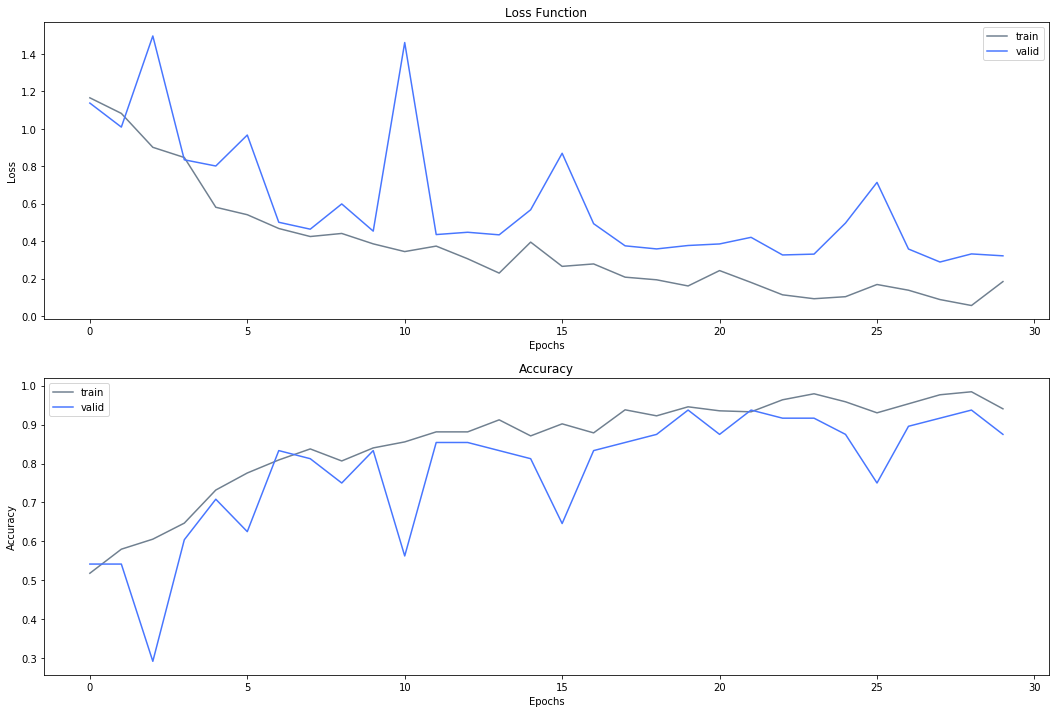

In [34]:
hide_code
# Plot the training history
history_plot(cc_history)

In [35]:
hide_code
# Load the model with the best validation accuracy
cc_model.load_weights('weights.best.decor.cc_model.hdf5')
# Calculate classification accuracy on the testing set
cc_score = cc_model.evaluate(x_test, y_test)
cc_score

49/49 [==============================] - 3s     


[0.42190671696954846, 0.85714286200854239]

In [55]:
hide_code
def cd_model(leaky_alpha):
    model = Sequential()
    # TODO: Define a model architecture
    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
    model.add(LeakyReLU(alpha=leaky_alpha))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(96, (5, 5)))
    model.add(LeakyReLU(alpha=leaky_alpha))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalMaxPooling2D()) 
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=leaky_alpha))
    model.add(Dropout(0.25)) 
    
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

In [56]:
hide_code
# Train the model
cd_model = cd_model(0.025)
cd_checkpointer = ModelCheckpoint(filepath='weights.best.decor.cd_model.hdf5', 
                                  verbose=2, save_best_only=True)
cd_history = cd_model.fit(x_train3, y_train3, 
                          epochs=30, batch_size=16, verbose=2,
                          validation_data=(x_valid3, y_valid3),
                          callbacks=[cd_checkpointer])

Train on 388 samples, validate on 48 samples
Epoch 1/30
Epoch 00000: val_loss improved from inf to 1.52758, saving model to weights.best.decor.cd_model.hdf5
92s - loss: 1.8197 - acc: 0.3041 - val_loss: 1.5276 - val_acc: 0.4792
Epoch 2/30
Epoch 00001: val_loss did not improve
72s - loss: 1.3313 - acc: 0.4407 - val_loss: 1.6802 - val_acc: 0.2708
Epoch 3/30
Epoch 00002: val_loss improved from 1.52758 to 1.15408, saving model to weights.best.decor.cd_model.hdf5
76s - loss: 1.0453 - acc: 0.6108 - val_loss: 1.1541 - val_acc: 0.6042
Epoch 4/30
Epoch 00003: val_loss improved from 1.15408 to 0.98052, saving model to weights.best.decor.cd_model.hdf5
64s - loss: 0.9160 - acc: 0.6469 - val_loss: 0.9805 - val_acc: 0.5417
Epoch 5/30
Epoch 00004: val_loss improved from 0.98052 to 0.88258, saving model to weights.best.decor.cd_model.hdf5
66s - loss: 0.7717 - acc: 0.7139 - val_loss: 0.8826 - val_acc: 0.7292
Epoch 6/30
Epoch 00005: val_loss did not improve
63s - loss: 0.6865 - acc: 0.7500 - val_loss: 1.

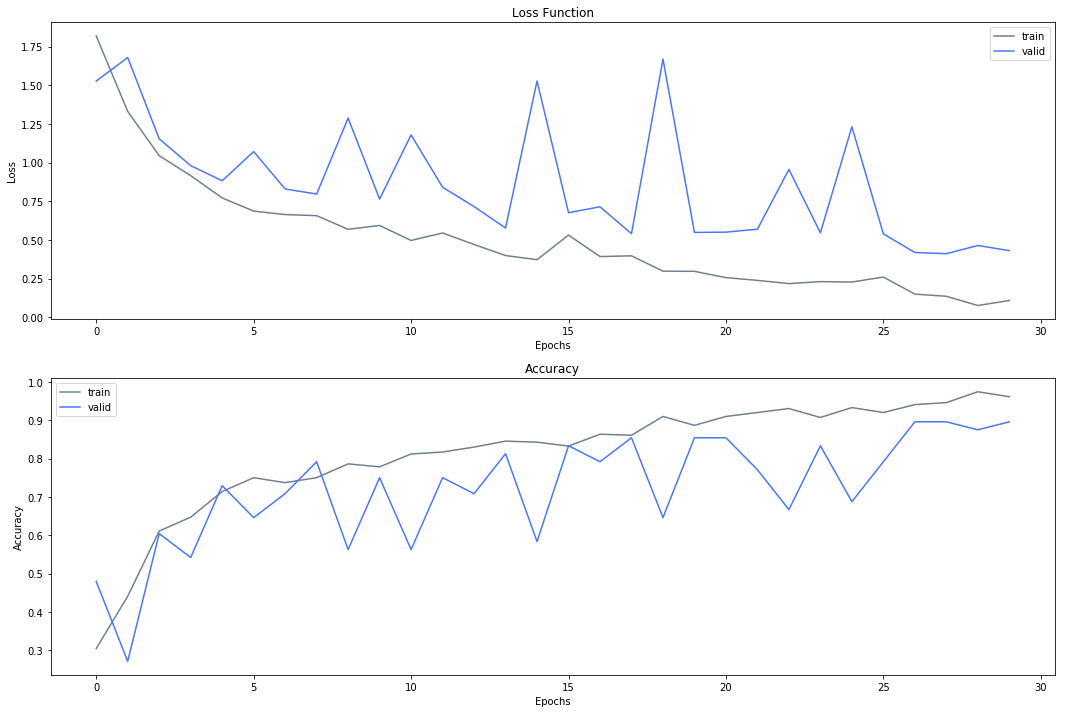

In [57]:
hide_code
# Plot the training history
history_plot(cd_history)

In [58]:
hide_code
# Load the model with the best validation accuracy
cd_model.load_weights('weights.best.decor.cd_model.hdf5')
# Calculate classification accuracy on the testing set
cd_score = cd_model.evaluate(x_test3, y_test3)
cd_score

49/49 [==============================] - 2s     


[0.50199888798655301, 0.87755102405742724]

In [59]:
hide_code
# Save experiment results for test points/ 30 epochs
leaky_alphas = np.array([0.005, 0.01, 0.015, 0.02, 0.025])
cd_losses_30 = np.array([0.47320266524139715, 0.63012125540752795, 0.45978901459246263, 
                         0.50793846650999419, 0.50199888798655301])
cd_accuracies_30 = np.array([0.87755102405742724, 0.81632653547793022, 0.83673469995965766, 
                             0.89795918610631198, 0.87755102405742724])

In [56]:
hide_code
# Save experiment results for test points/ 20 epochs
cd_losses_20 = np.array([0.65711019720349995, 0.66739930911939971, 0.59441830917280547, 
                         0.66775868863475563, 0.68195151066293525])
cd_accuracies_20 = np.array([0.83673469874323636, 0.79591837342904537, 0.81632653669435151, 
                             0.79591837342904537, 0.81632653547793022])

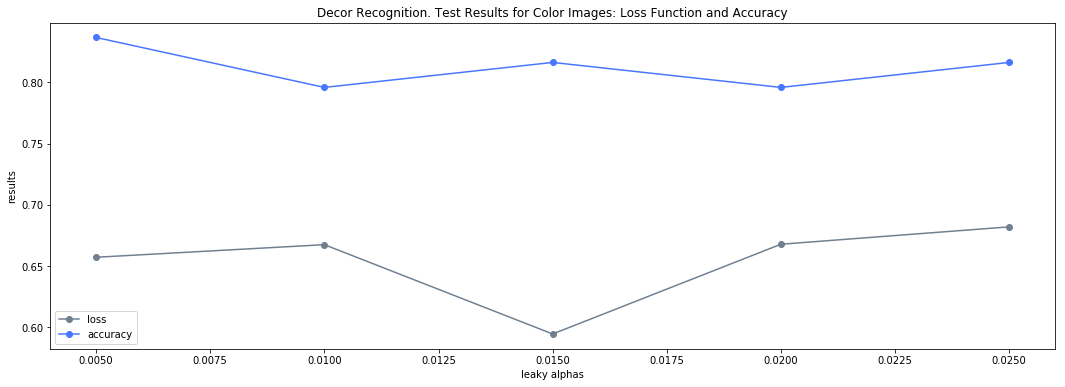

In [60]:
hide_code
# Plot the results
plt.figure(figsize=(18, 6))
plt.plot(leaky_alphas, cd_losses_20, '-o', color='slategray', label = 'loss')
plt.plot(leaky_alphas, cd_accuracies_20, '-o', color='#4876ff', label = 'accuracy')
plt.xlabel('leaky alphas')
plt.ylabel('results')
plt.legend(loc=3)
plt.title('Decor Recognition. Test Results for Color Images: Loss Function and Accuracy');

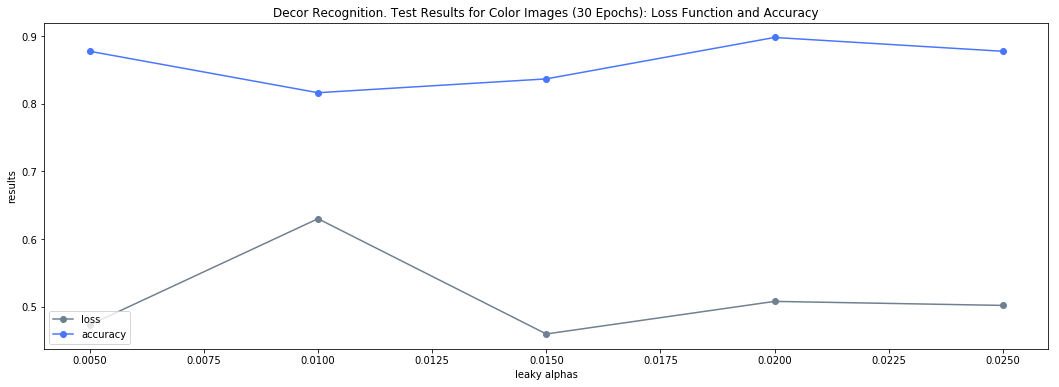

In [60]:
hide_code
# Plot the results
plt.figure(figsize=(18, 6))
plt.plot(leaky_alphas, cd_losses_30, '-o', color='slategray', label = 'loss')
plt.plot(leaky_alphas, cd_accuracies_30, '-o', color='#4876ff', label = 'accuracy')
plt.xlabel('leaky alphas')
plt.ylabel('results')
plt.legend(loc=3)
plt.title('Decor Recognition. Test Results for Color Images (30 Epochs): Loss Function and Accuracy');

#### Country & Decor Recognition for Grayscaled Images

In [41]:
hide_code
def gray_cc_model():
    model = Sequential()
    
    # TODO: Define a model architecture
    model.add(Conv2D(16, (5, 5), padding='same', input_shape=x_train4.shape[1:]))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (5, 5)))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalMaxPooling2D()) 
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25))   

    model.add(Dense(4))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [42]:
hide_code
# Train the model
gray_cc_model = gray_cc_model()
gray_cc_checkpointer = ModelCheckpoint(filepath='weights.best.decor.gray_cc_model.hdf5', 
                                       verbose=2, save_best_only=True)
gray_cc_history = gray_cc_model.fit(x_train2, y_train2, 
                                    epochs=30, batch_size=16, verbose=2,
                                    validation_data=(x_valid2, y_valid2),
                                    callbacks=[gray_cc_checkpointer])

Train on 388 samples, validate on 48 samples
Epoch 1/30
Epoch 00000: val_loss improved from inf to 1.26412, saving model to weights.best.decor.gray_cc_model.hdf5
37s - loss: 1.2031 - acc: 0.5696 - val_loss: 1.2641 - val_acc: 0.5417
Epoch 2/30
Epoch 00001: val_loss improved from 1.26412 to 1.25645, saving model to weights.best.decor.gray_cc_model.hdf5
38s - loss: 1.1250 - acc: 0.5876 - val_loss: 1.2564 - val_acc: 0.5417
Epoch 3/30
Epoch 00002: val_loss improved from 1.25645 to 1.15836, saving model to weights.best.decor.gray_cc_model.hdf5
40s - loss: 1.1101 - acc: 0.5876 - val_loss: 1.1584 - val_acc: 0.5417
Epoch 4/30
Epoch 00003: val_loss did not improve
42s - loss: 1.0966 - acc: 0.5876 - val_loss: 1.1735 - val_acc: 0.5417
Epoch 5/30
Epoch 00004: val_loss did not improve
36s - loss: 1.0862 - acc: 0.5876 - val_loss: 1.2952 - val_acc: 0.5417
Epoch 6/30
Epoch 00005: val_loss did not improve
39s - loss: 1.0735 - acc: 0.5876 - val_loss: 1.3284 - val_acc: 0.5417
Epoch 7/30
Epoch 00006: val_l

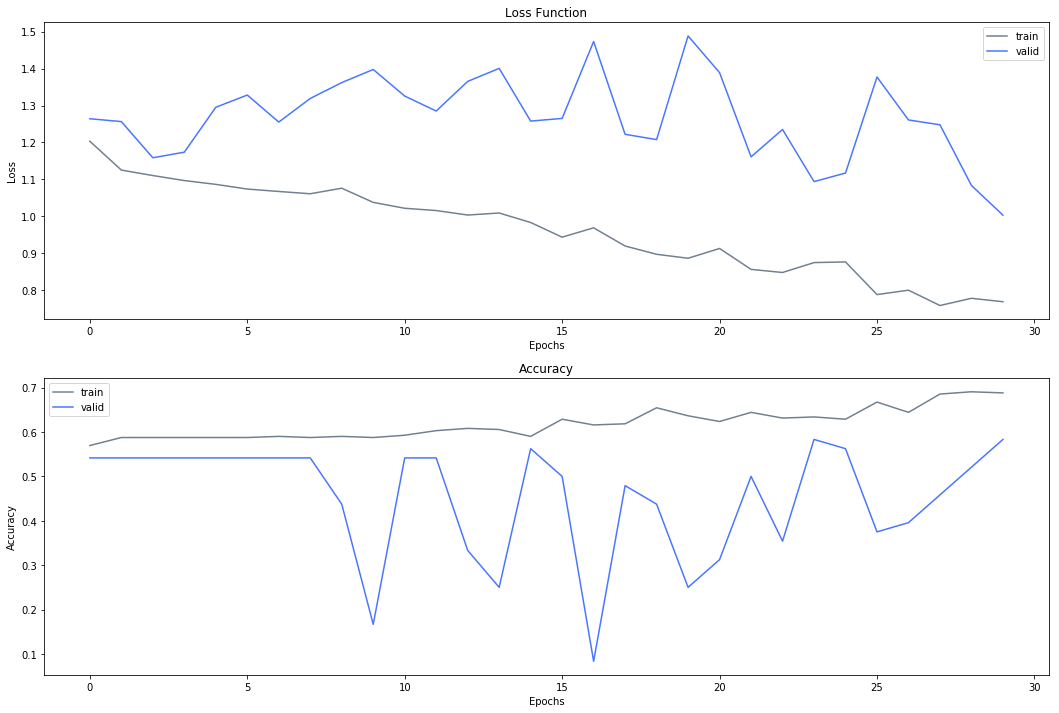

In [43]:
hide_code
# Plot the training history
history_plot(gray_cc_history)

In [44]:
hide_code
# Load the model with the best validation accuracy
gray_cc_model.load_weights('weights.best.decor.gray_cc_model.hdf5')
# Calculate classification accuracy on the testing set
gray_cc_score = gray_cc_model.evaluate(x_test2, y_test2)
gray_cc_score

49/49 [==============================] - 1s     


[1.163997127085316, 0.5306122546293297]

In [79]:
hide_code
def gray_cd_model(leaky_alpha):
    model = Sequential()
    
    # TODO: Define a model architecture
    model.add(Conv2D(16, (5, 5), padding='same', input_shape=x_train4.shape[1:]))
    model.add(LeakyReLU(alpha=leaky_alpha))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (5, 5)))
    model.add(LeakyReLU(alpha=leaky_alpha))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalMaxPooling2D()) 
    
    model.add(Dense(1024, activation='tanh'))
    model.add(Dropout(0.25))   

    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [80]:
hide_code
# Train the model
gray_cd_model = gray_cd_model(0.025)
gray_cd_checkpointer = ModelCheckpoint(filepath='weights.best.decor.gray_cd_model.hdf5', 
                                       verbose=2, save_best_only=True)
gray_cd_history = gray_cd_model.fit(x_train4, y_train4, 
                                    epochs=30, batch_size=16, verbose=2,
                                    validation_data=(x_valid4, y_valid4),
                                    callbacks=[gray_cd_checkpointer])

Train on 388 samples, validate on 48 samples
Epoch 1/30
Epoch 00000: val_loss improved from inf to 1.92881, saving model to weights.best.decor.gray_cd_model.hdf5
31s - loss: 1.9618 - acc: 0.1753 - val_loss: 1.9288 - val_acc: 0.1875
Epoch 2/30
Epoch 00001: val_loss improved from 1.92881 to 1.92209, saving model to weights.best.decor.gray_cd_model.hdf5
28s - loss: 1.8920 - acc: 0.2294 - val_loss: 1.9221 - val_acc: 0.1875
Epoch 3/30
Epoch 00002: val_loss did not improve
27s - loss: 1.8585 - acc: 0.2242 - val_loss: 1.9418 - val_acc: 0.1875
Epoch 4/30
Epoch 00003: val_loss did not improve
27s - loss: 1.8301 - acc: 0.2655 - val_loss: 1.9599 - val_acc: 0.2292
Epoch 5/30
Epoch 00004: val_loss did not improve
31s - loss: 1.7780 - acc: 0.2784 - val_loss: 1.9389 - val_acc: 0.1875
Epoch 6/30
Epoch 00005: val_loss improved from 1.92209 to 1.87551, saving model to weights.best.decor.gray_cd_model.hdf5
27s - loss: 1.7342 - acc: 0.2577 - val_loss: 1.8755 - val_acc: 0.2083
Epoch 7/30
Epoch 00006: val_l

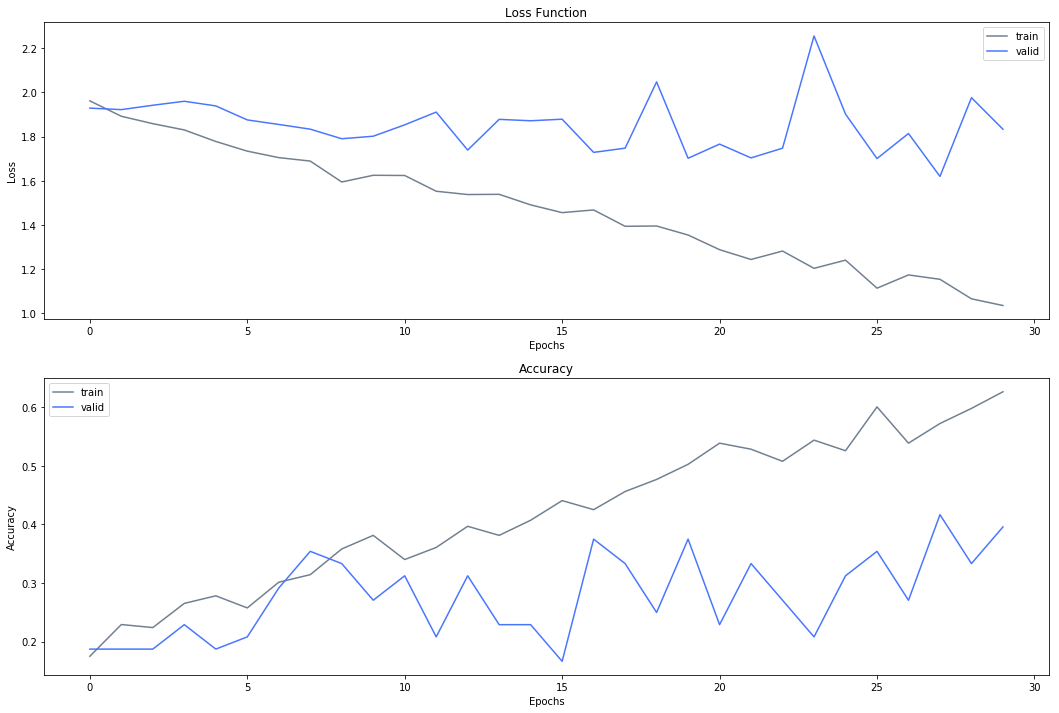

In [81]:
hide_code
# Plot the training history
history_plot(gray_cd_history)

In [82]:
hide_code
# Load the model with the best validation accuracy
gray_cd_model.load_weights('weights.best.decor.gray_cd_model.hdf5')
# Calculate classification accuracy on the testing set
gray_cd_score = gray_cd_model.evaluate(x_test4, y_test4)
gray_cd_score

49/49 [==============================] - 1s     


[1.5720605558278609, 0.36734693907961552]

In [61]:
hide_code
# Save experiment results for test points / 30 epochs 
# Exp #1: 1st - Conv2D(32, (5, 5)), 2nd - Conv2D(128, (5, 5))
leaky_alphas = np.array([0.005, 0.01, 0.015, 0.02, 0.025])

gray_cd_losses = np.array([1.777957059899155, 1.6141312146673397, 1.6672236432834548, 
                           2.0078208689786949, 1.8407663958413261])
gray_cd_accuracies = np.array([0.26530612260103226, 0.34693877581430943, 0.28571428579031205, 
                               0.224489797438894, 0.30612245050011849])

In [76]:
hide_code
# Save experiment results for test points / 30 epochs / 
# Exp #2: 1st - Conv2D(64, (5, 5)), 2nd - Conv2D(256, (5, 5))

gray_cd_losses2 = np.array([1.6528263238011573, 1.7795450176511491, 1.6591916619514933, 
                           1.6295414554829499, 1])
gray_cd_accuracies2 = np.array([0.32653061650237258, 0.20408163417358788, 0.30612245050011849, 
                               0.24489796070420011, 0])

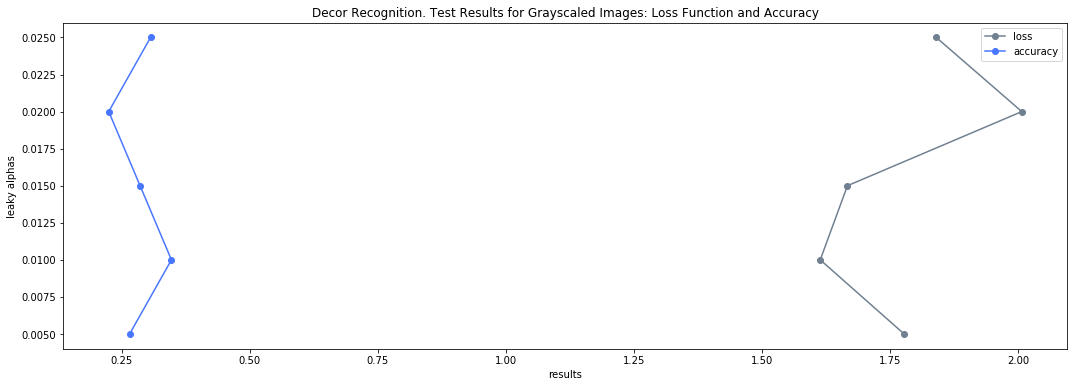

In [77]:
hide_code
# Plot the results
plt.figure(figsize=(18, 6))
plt.plot(gray_cd_losses, leaky_alphas, '-o', color='slategray', label = 'loss')
plt.plot(gray_cd_accuracies, leaky_alphas, '-o', color='#4876ff', label = 'accuracy')
plt.xlabel('results')
plt.ylabel('leaky alphas')
plt.legend()
plt.title('Decor Recognition. Test Results for Grayscaled Images: Loss Function and Accuracy');

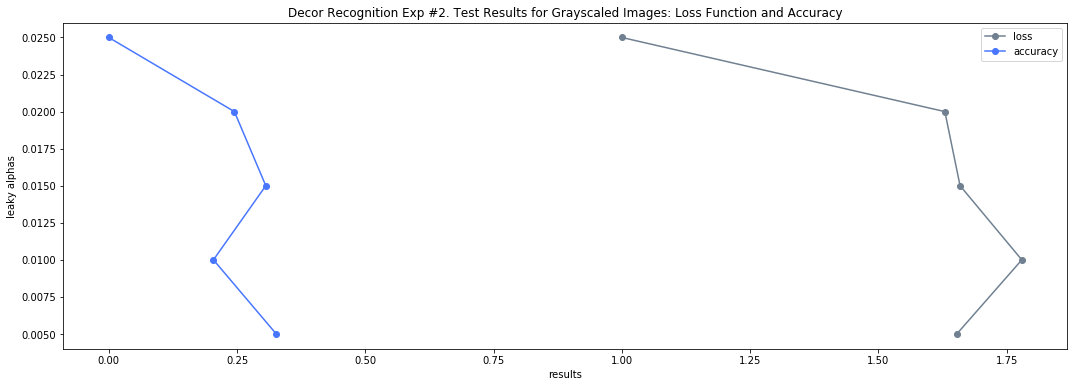

In [78]:
hide_code
# Plot the results
plt.figure(figsize=(18, 6))
plt.plot(gray_cd_losses2, leaky_alphas, '-o', color='slategray', label = 'loss')
plt.plot(gray_cd_accuracies2, leaky_alphas, '-o', color='#4876ff', label = 'accuracy')
plt.xlabel('results')
plt.ylabel('leaky alphas')
plt.legend()
plt.title('Decor Recognition Exp #2. Test Results for Grayscaled Images: Loss Function and Accuracy');

## Step 5. Create Neural Networks for Multi-Label Classification

In [34]:
hide_code
def multi_model(leaky_alpha):    
    model_input = Input(shape=(150, 150, 3))
    x = BatchNormalization()(model_input)
    # TODO: Define a model architecture
    x = Conv2D(32, (5, 5), padding='same')(model_input)
    x = LeakyReLU(alpha=leaky_alpha)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (5, 5), padding='same')(x)
    x = LeakyReLU(alpha=leaky_alpha)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
              
    x = GlobalMaxPooling2D()(x)
    
    x = Dense(512)(x) 
    x = LeakyReLU(alpha=leaky_alpha)(x)
    x = Dropout(0.25)(x)
    
    y1 = Dense(4, activation='softmax')(x)
    y2 = Dense(7, activation='softmax')(x)
    y3 = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=model_input, outputs=[y1, y2, y3])
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

In [259]:
hide_code
# Train the model
multi_model = multi_model(0.005)
multi_checkpointer = ModelCheckpoint(filepath='weights.best.decor.multi_model.hdf5', 
                                     verbose=2, save_best_only=True)
multi_history = multi_model.fit(x_train5, y_train5_list, 
                                epochs=20, batch_size=16, verbose=2,
                                validation_data=(x_valid5, y_valid5_list),
                                callbacks=[multi_checkpointer])

Train on 388 samples, validate on 48 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 3.69059, saving model to weights.best.decor.multi_model.hdf5
125s - loss: 3.8243 - dense_104_loss: 1.1645 - dense_105_loss: 1.9464 - dense_106_loss: 0.7133 - dense_104_acc: 0.5644 - dense_105_acc: 0.2294 - dense_106_acc: 0.5412 - val_loss: 3.6906 - val_dense_104_loss: 1.1744 - val_dense_105_loss: 1.8285 - val_dense_106_loss: 0.6877 - val_dense_104_acc: 0.4375 - val_dense_105_acc: 0.2500 - val_dense_106_acc: 0.5208
Epoch 2/20
Epoch 00001: val_loss improved from 3.69059 to 3.44568, saving model to weights.best.decor.multi_model.hdf5
93s - loss: 3.4733 - dense_104_loss: 1.1045 - dense_105_loss: 1.6296 - dense_106_loss: 0.7391 - dense_104_acc: 0.5335 - dense_105_acc: 0.3582 - dense_106_acc: 0.4974 - val_loss: 3.4457 - val_dense_104_loss: 1.0960 - val_dense_105_loss: 1.6365 - val_dense_106_loss: 0.7132 - val_dense_104_acc: 0.6042 - val_dense_105_acc: 0.4167 - val_dense_106_acc: 0.4792
Epoch 3/

Epoch 00019: val_loss did not improve
77s - loss: 29.2452 - dense_104_loss: 6.6466 - dense_105_loss: 14.4980 - dense_106_loss: 8.1006 - dense_104_acc: 0.5876 - dense_105_acc: 0.1005 - dense_106_acc: 0.4974 - val_loss: 28.5425 - val_dense_104_loss: 7.3875 - val_dense_105_loss: 13.4317 - val_dense_106_loss: 7.7233 - val_dense_104_acc: 0.5417 - val_dense_105_acc: 0.1667 - val_dense_106_acc: 0.5208


In [260]:
hide_code
# Load the model with the best validation accuracy
multi_model.load_weights('weights.best.decor.multi_model.hdf5')
# Calculate classification accuracy on the testing set
multi_scores = multi_model.evaluate(x_test5, y_test5_list, verbose=0)

print("Scores: \n" , (multi_scores))
print("Country label. Accuracy: %.2f%%" % (multi_scores[4]*100))
print("Decor label. Accuracy: %.2f%%" % (multi_scores[5]*100))
print("Type label. Accuracy: %.2f%%" % (multi_scores[6]*100))

Scores: 
 [2.3588784957418638, 0.79491684874709767, 0.82905603671560479, 0.734905651637486, 0.77551021138016063, 0.75510204933127578, 0.59183673651850954]
Country label. Accuracy: 77.55%
Decor label. Accuracy: 75.51%
Type label. Accuracy: 59.18%


In [41]:
hide_code
# Save experiment results for test points / 20 epochs
leaky_alphas = np.array([0.005, 0.01, 0.015, 0.02, 0.025])

multi_losses = np.array([2.3588784957418638, 2.4497200274954039, 3.1632251155619717, 
                         2.7588427845312626, 2.400767063607975])
multi_losses1 = np.array([0.79491684874709767, 0.78207657531816133, 0.84956139447737711, 
                          0.926974564182515, 0.7789653004432211])
multi_losses2 = np.array([0.82905603671560479, 0.98002039899631421, 1.0824525891518106, 
                          1.1792272621271562, 0.98129088294749356])
multi_losses3 = np.array([0.734905651637486, 0.68762307386009058, 1.2312110930073017, 
                          0.65264103850539845, 0.64051082304545814])

multi_accuracies1 = np.array([0.77551021138016063, 0.75510204933127578, 0.65306122509800657, 
                              0.67346939627005131, 0.67346939627005131])
multi_accuracies2 = np.array([0.75510204933127578, 0.63265306852301773, 0.55102041789463585, 
                              0.5714285787270994, 0.61224490525771158])
multi_accuracies3 = np.array([0.59183673651850954, 0.67346939748647261, 0.32653061376542464, 
                              0.59183674199240544, 0.67346939383720861])

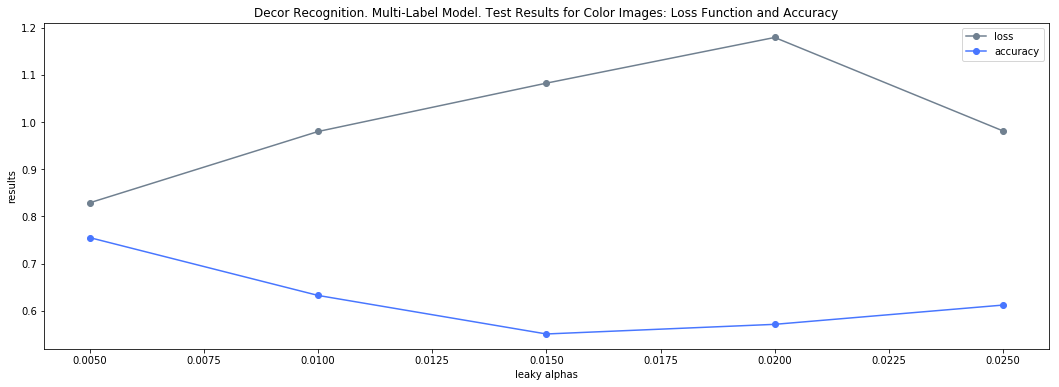

In [42]:
hide_code
# Plot the results
plt.figure(figsize=(18, 6))
plt.plot(leaky_alphas, multi_losses2, '-o', color='slategray', label = 'loss')
plt.plot(leaky_alphas, multi_accuracies2, '-o', color='#4876ff', label = 'accuracy')
plt.xlabel('leaky alphas')
plt.ylabel('results')
plt.legend()
plt.title('Decor Recognition. Multi-Label Model. Test Results for Color Images: Loss Function and Accuracy');

In [36]:
hide_code
def gray_multi_model(leaky_alpha):    
    model_input = Input(shape=(150, 150, 1))
    x = BatchNormalization()(model_input)
    # TODO: Define a model architecture
    x = Conv2D(32, (5, 5), padding='same')(model_input)
    x = LeakyReLU(alpha=leaky_alpha)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(256, (5, 5), padding='same')(x)
    x = LeakyReLU(alpha=leaky_alpha)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
              
    x = GlobalMaxPooling2D()(x)
    
    x = Dense(2048)(x) 
    x = LeakyReLU(alpha=leaky_alpha)(x)
    x = Dropout(0.25)(x)
    
    y1 = Dense(4, activation='softmax')(x)
    y2 = Dense(7, activation='softmax')(x)
    y3 = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=model_input, outputs=[y1, y2, y3])
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

In [37]:
hide_code
# Train the model
gray_multi_model = gray_multi_model(0.005)
gray_multi_checkpointer = ModelCheckpoint(filepath='weights.best.decor.gray_multi_model.hdf5', 
                                          verbose=2, save_best_only=True)
gray_multi_history = gray_multi_model.fit(x_train6, y_train6_list, 
                                          epochs=20, batch_size=16, verbose=2,
                                          validation_data=(x_valid6, y_valid6_list),
                                          callbacks=[gray_multi_checkpointer])

Train on 388 samples, validate on 48 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 3.75423, saving model to weights.best.decor.gray_multi_model.hdf5
138s - loss: 4.0302 - dense_4_loss: 1.1822 - dense_5_loss: 1.9907 - dense_6_loss: 0.8574 - dense_4_acc: 0.5722 - dense_5_acc: 0.2062 - dense_6_acc: 0.5129 - val_loss: 3.7542 - val_dense_4_loss: 1.1282 - val_dense_5_loss: 1.9335 - val_dense_6_loss: 0.6925 - val_dense_4_acc: 0.5417 - val_dense_5_acc: 0.1875 - val_dense_6_acc: 0.4792
Epoch 2/20
Epoch 00001: val_loss did not improve
136s - loss: 3.8064 - dense_4_loss: 1.1418 - dense_5_loss: 1.9399 - dense_6_loss: 0.7247 - dense_4_acc: 0.5876 - dense_5_acc: 0.2165 - dense_6_acc: 0.4691 - val_loss: 3.7709 - val_dense_4_loss: 1.1595 - val_dense_5_loss: 1.9204 - val_dense_6_loss: 0.6909 - val_dense_4_acc: 0.5417 - val_dense_5_acc: 0.1667 - val_dense_6_acc: 0.4792
Epoch 3/20
Epoch 00002: val_loss did not improve
127s - loss: 3.7253 - dense_4_loss: 1.1218 - dense_5_loss: 1.9234 - den

In [38]:
hide_code
# Load the model with the best validation accuracy
gray_multi_model.load_weights('weights.best.decor.gray_multi_model.hdf5')
# Calculate classification accuracy on the testing set
gray_multi_scores = gray_multi_model.evaluate(x_test6, y_test6_list, verbose=0)

print("Scores: \n" , (gray_multi_scores))
print("Country label. Accuracy: %.2f%%" % (gray_multi_scores[4]*100))
print("Decor label. Accuracy: %.2f%%" % (gray_multi_scores[5]*100))
print("Type label. Accuracy: %.2f%%" % (gray_multi_scores[6]*100))

Scores: 
 [3.9903284724877803, 1.2824076097838732, 2.0234891297865887, 0.68443163438719146, 0.44897960156810529, 0.12244897966786307, 0.67346939140436601]
Country label. Accuracy: 44.90%
Decor label. Accuracy: 12.24%
Type label. Accuracy: 67.35%


In [43]:
hide_code
# Save experiment results for test points / 20 epochs
gray_multi_losses = np.array([3.9903284724877803, 3.5339538759114792, 3.9035351130427145, 
                              3.7997477687135035, 4.0967560203707949])
gray_multi_losses1 = np.array([1.2824076097838732, 1.1924295376758187, 1.2683943193785998, 
                               1.2840366728451786, 1.2667128188269479])
gray_multi_losses2 = np.array([2.0234891297865887, 1.7557842196250448, 1.9094033581869942, 
                               1.8746722863644969, 1.9847604109316457])
gray_multi_losses3 = np.array([0.68443163438719146, 0.58574000183416874, 0.72573739655163827, 
                               0.64103872922002048, 0.84528285021684613])
 
gray_multi_accuracies1 = np.array([0.44897960156810529, 0.48979592809871753, 0.44897960156810529, 
                                   0.44897960156810529, 0.44897960156810529])
gray_multi_accuracies2 = np.array([0.12244897966786307, 0.24489796222472676, 0.22448979622247267, 
                                   0.30612244928369714, 0.16326530619847532])
gray_multi_accuracies3 = np.array([0.67346939140436601, 0.65306123300474517, 0.32653061376542464, 
                                   0.67346939140436601, 0.32653061376542464])

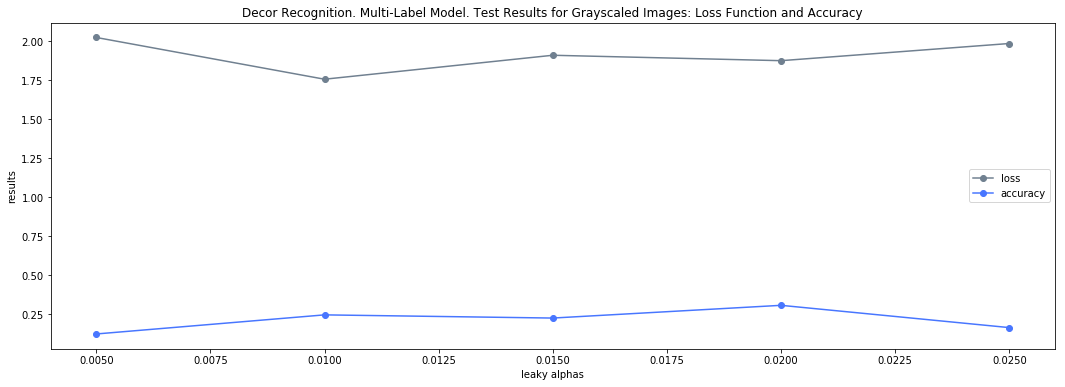

In [44]:
hide_code
# Plot the results
plt.figure(figsize=(18, 6))
plt.plot(leaky_alphas, gray_multi_losses2, '-o', color='slategray', label = 'loss')
plt.plot(leaky_alphas, gray_multi_accuracies2, '-o', color='#4876ff', label = 'accuracy')
plt.xlabel('leaky alphas')
plt.ylabel('results')
plt.legend()
plt.title('Decor Recognition. Multi-Label Model. Test Results for Grayscaled Images: Loss Function and Accuracy');